# Gilled Mushrooms from Agaricus and Lepiota Family - features selection and models testing

### Classifications: Decision Tree, Random Forest and important features selection

Work with all features to identify those that are relevant based on statistical methods

Finalize the choice of features based on both statistical results and practical reasons: for example, in case gill spacing is identified as the most important feature, I would still be hesitant to include it. According to the description of the dataset, gill spacing could be described as close=c, crowded=w or distant=d but in real life, non-professional would have difficulties distinguishing between those, while features like colors or odors are easier to spot.

__Analysis technics__:

All of my data is categorical, therefore, I am unable to use Principal Component Analysis (PCA) for feature selection as it applies to contnious data and sometimes for dummies

In [1]:
import re, csv, os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import  classification_report, accuracy_score, confusion_matrix
%matplotlib inline

/Users/dariaulybina/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/dariaulybina/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df = pd.read_csv('/Users/dariaulybina/Desktop/georgetown/ml_practice/data/data.csv')
df = df.drop(df.columns[[0]], axis=1)  
df.head()

,classif,cap_shape,cap_surface,cap_colour,bruises,odor,gill_attach,gill_space,gill_size,gill_color,...,stalk_surf_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,Poisonous,x,s,Brown,Bruises,Pungent,f,Close,Narrow,Black,...,s,White,White,p,w,o,Pendant,Black,Scattered,Urban
1,Etable,x,s,Yellow,Bruises,Almond,f,Close,Broad,Black,...,s,White,White,p,w,o,Pendant,Brown,Numerous,Grasses
2,Etable,b,s,White,Bruises,Anise,f,Close,Broad,Brown,...,s,White,White,p,w,o,Pendant,Brown,Numerous,Meadows
3,Poisonous,x,y,White,Bruises,Pungent,f,Close,Narrow,Brown,...,s,White,White,p,w,o,Pendant,Black,Scattered,Urban
4,Etable,x,s,Gray,No,None,f,Crowded,Broad,Black,...,s,White,White,p,w,o,Evanescent,Brown,Abundant,Grasses


In [3]:
df.describe()

,classif,cap_shape,cap_surface,cap_colour,bruises,odor,gill_attach,gill_space,gill_size,gill_color,...,stalk_surf_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,Etable,x,y,Brown,No,None,f,Close,Broad,Buff,...,s,White,White,p,w,o,Pendant,White,Several,Woods
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [4]:
cnames = df.columns
print(cnames)

Index(['classif', 'cap_shape', 'cap_surface', 'cap_colour', 'bruises', 'odor',
       'gill_attach', 'gill_space', 'gill_size', 'gill_color', 'stalk_shape',
       'stalk_surf_above_ring', 'stalk_surf_below_ring',
       'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type',
       'veil_color', 'ring_number', 'ring_type', 'spore_print_color',
       'population', 'habitat'],
      dtype='object')


In [5]:
y = df[['classif']]
#X = df[['cap_colour','odor','gill_color','stalk_color_above_ring','stalk_color_below_ring','habitat']]
#print(X.head())

In [6]:
table = pd.crosstab(index=df['classif'], columns="count")
table

col_0,count
classif,
Etable,4208
Poisonous,3916


In [7]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
       
    
    def inverse_transform(self, X):
        result = X.copy()
        for idx, column in self.encoders.items():
            result[column] = encoder.inverse_transform(X[column])
        return result

In [9]:
dfx = df.drop(df.columns[[0]], axis=1)
X = MultiColumnLabelEncoder(columns = ['cap_shape', 'cap_surface', 'cap_colour', 'bruises', 'odor',
       'gill_attach', 'gill_space', 'gill_size', 'gill_color', 'stalk_shape',
       'stalk_surf_above_ring', 'stalk_surf_below_ring',
       'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type',
       'veil_color', 'ring_number', 'ring_type', 'spore_print_color',
       'population', 'habitat']).fit_transform(dfx)
X

,cap_shape,cap_surface,cap_colour,bruises,odor,gill_attach,gill_space,gill_size,gill_color,stalk_shape,...,stalk_surf_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,5,2,0,0,7,1,0,1,0,0,...,2,7,7,0,2,1,4,0,3,4
1,5,2,9,0,0,1,0,0,0,0,...,2,7,7,0,2,1,4,1,2,0
2,0,2,8,0,1,1,0,0,1,0,...,2,7,7,0,2,1,4,1,2,2
3,5,3,8,0,7,1,0,1,1,0,...,2,7,7,0,2,1,4,0,3,4
4,5,2,3,1,6,1,1,0,0,1,...,2,7,7,0,2,1,0,1,0,0
5,5,3,9,0,0,1,0,0,1,0,...,2,7,7,0,2,1,4,0,2,0
6,0,2,8,0,0,1,0,0,4,0,...,2,7,7,0,2,1,4,0,2,2
7,0,3,8,0,1,1,0,0,1,0,...,2,7,7,0,2,1,4,1,3,2
8,5,3,8,0,7,1,0,1,7,0,...,2,7,7,0,2,1,4,0,4,0
9,0,2,9,0,0,1,0,0,4,0,...,2,7,7,0,2,1,4,0,3,2


In [10]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['classif'])

In [11]:
y

array([1, 0, 0, ..., 0, 1, 0])

In [12]:
from sklearn.pipeline import Pipeline

encoding_pipeline = Pipeline([
        ('encoding',MultiColumnLabelEncoder())
    ])
A = encoding_pipeline.fit_transform(X)
A

,cap_shape,cap_surface,cap_colour,bruises,odor,gill_attach,gill_space,gill_size,gill_color,stalk_shape,...,stalk_surf_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,5,2,0,0,7,1,0,1,0,0,...,2,7,7,0,2,1,4,0,3,4
1,5,2,9,0,0,1,0,0,0,0,...,2,7,7,0,2,1,4,1,2,0
2,0,2,8,0,1,1,0,0,1,0,...,2,7,7,0,2,1,4,1,2,2
3,5,3,8,0,7,1,0,1,1,0,...,2,7,7,0,2,1,4,0,3,4
4,5,2,3,1,6,1,1,0,0,1,...,2,7,7,0,2,1,0,1,0,0
5,5,3,9,0,0,1,0,0,1,0,...,2,7,7,0,2,1,4,0,2,0
6,0,2,8,0,0,1,0,0,4,0,...,2,7,7,0,2,1,4,0,2,2
7,0,3,8,0,1,1,0,0,1,0,...,2,7,7,0,2,1,4,1,3,2
8,5,3,8,0,7,1,0,1,7,0,...,2,7,7,0,2,1,4,0,4,0
9,0,2,9,0,0,1,0,0,4,0,...,2,7,7,0,2,1,4,0,3,2


In [13]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.2)
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (6499, 21)
X_test Shape: (1625, 21)
y_train Shape: (6499,)
y_test Shape: (1625,)


Accuracy Score 1.0


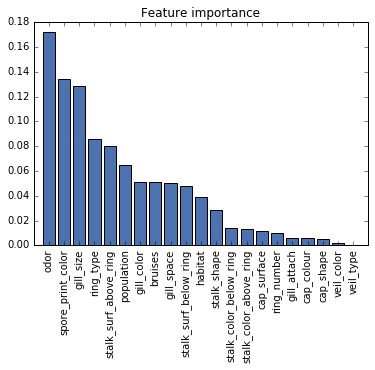

In [14]:
#Random Forest Classifier - results + important features
for i in range(1,30):
    random_forest = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    random_forest.fit(X_train, y_train)
    pred = random_forest.predict(X_test)
    acc = accuracy_score(y_test, pred)
print("Accuracy Score {}".format(acc))

#Graph most important features 
importances = random_forest.feature_importances_
features = A.columns[:]
sort_indices = np.argsort(importances)[::-1]
sorted_features = []
for idx in sort_indices:
    sorted_features.append(features[idx])
plt.figure()
plt.bar(range(len(importances)), importances[sort_indices], align='center', color ='#4C72B0');
plt.xticks(range(len(importances)), sorted_features, rotation='vertical');
plt.xlim([-1, len(importances)])
plt.title('Feature importance')
plt.grid(False)
    

__Most Important Features comments:__

Most important features identified are gill_size, spore print color, odor, bruises and then ring type, gill spacing stalk colors and polpulation. However, I won't choose the top features identified with Random Forest classifer  - but rather, after including practical considerations, I will include those features, that seem to be the most straight forward and fastest to spot in real situation. My decision will be based on analysis done in the previous notebook. 

My final list of feature: ['odor', 'ring_type', 'population', 'cap_colour']. I will run few basic models using default hyperparameters to decide on the best model to chose. 

In [15]:
data = df[['habitat', 'cap_colour','odor']]
data.head()

,habitat,cap_colour,odor
0,Urban,Brown,Pungent
1,Grasses,Yellow,Almond
2,Meadows,White,Anise
3,Urban,White,Pungent
4,Grasses,Gray,None


### Comments<br>

According to <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">Scklearn documentation</a>, One Hot Encoding is needed for feeding categorical data to linear models and SVMs with the standard kernels. I will create two encoding piplines that will evaluate few models with default parameters. In case linear SVC won't work, I will proceed trying other model, following the directions of sklearn cheet sheet for model choices.

In [16]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['classif'])
y

array([1, 0, 0, ..., 0, 1, 0])

In [17]:
#linear and svm models
from sklearn.preprocessing import OneHotEncoder

encoding_pipeline = Pipeline([
        ('encoding',MultiColumnLabelEncoder()),
        ('one_hot_encoder', OneHotEncoder())
    ])
B = encoding_pipeline.fit_transform(data)
B

<8124x26 sparse matrix of type '<class 'numpy.float64'>'
	with 24372 stored elements in Compressed Sparse Row format>

In [18]:
Xh_train, Xh_test, yh_train, yh_test = train_test_split(B, y, test_size=0.2, random_state=101)
print('X_train Shape:', Xh_train.shape)
print('X_test Shape:', Xh_test.shape)
print('y_train Shape:', yh_train.shape)
print('y_test Shape:', yh_test.shape)

X_train Shape: (6499, 26)
X_test Shape: (1625, 26)
y_train Shape: (6499,)
y_test Shape: (1625,)


In [19]:
#encoding for trees and forests
encoder = LabelEncoder()
y = encoder.fit_transform(df['classif'])

encoding_pipeline = Pipeline([
        ('encoding',MultiColumnLabelEncoder())
    ])
C = encoding_pipeline.fit_transform(data)
C.head()

,habitat,cap_colour,odor
0,4,0,7
1,0,9,0
2,2,8,1
3,4,8,7
4,0,3,6


In [20]:
X_train, X_test, y_train, y_test = train_test_split(C, y, test_size=0.2)
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (6499, 3)
X_test Shape: (1625, 3)
y_train Shape: (6499,)
y_test Shape: (1625,)


### Linear SVC

As was advised in the Sklearn Cheet Sheet on model selection, I will start with trying to explore and tune in my Linear Support Vector Classifier Model. 

### GridSearch, ShuffleSplit and Learning Curve Graph


In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [22]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(Xh_train.shape[0], n_iter=12, test_size=0.2, random_state=0)

In [23]:
from sklearn.svm import SVC
estimator = SVC(kernel='linear')

In [24]:
from sklearn.grid_search import GridSearchCV
import numpy as np
gammas = np.logspace(-6, -1, 10)
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=dict(gamma=gammas))
classifier.fit(Xh_train, yh_train)

GridSearchCV(cv=ShuffleSplit(6499, n_iter=12, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [25]:
print(classifier.best_score_)

0.993846153846


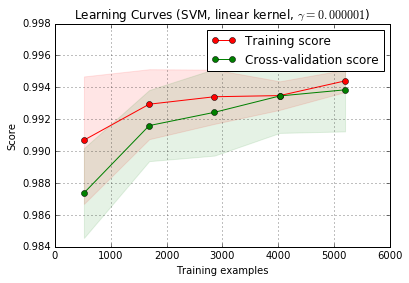

In [26]:
from sklearn.learning_curve import learning_curve
title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
estimator = SVC(kernel='linear', gamma=classifier.best_estimator_.gamma)
plot_learning_curve(estimator, title, Xh_train, yh_train, cv=cv)
plt.show()

__Interpretation of Learning Curve: Underfitting or Overfitting__

First I can see that the training score is around its maximum and the validation score could be increased with more training samples. Thus, this learning curve is helpful for finding out that the model benefits from adding more training data in this case. <br>

Adidtionally, I should be able to tell whether the estimator suffers more from a variance error or a bias error.

According to documentation, if two curves are "close to each other" and both of them have a low score - the model suffer from an under fitting problem (High Bias). Both cross-validation score and training scores are pretty high, not close to each other in the beginning, but definetly converging toward some higher score in the end. The training curve doesnt have 'significantly' better score than testing curve, the gap is not as large as it could be. Thus, the model doesnt suffer from overfitting (High Variance). However, if the difference between my scores was over 0.1 I should be worried about overfitting. However, I am noting that scores are on the boundary level and overfitting problem might become an issue. 



In [27]:
classifier.score(Xh_test, yh_test)

0.99261538461538457

In [28]:
estimator.fit(Xh_train, yh_train)
predh = estimator.predict(Xh_test)
print(classification_report(yh_test, predh))
acch = accuracy_score(yh_test, predh)
print("Accuracy Score: {} \n".format(acch))
print(confusion_matrix(yh_test, predh))
print('\n' + '\n')

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       851
          1       1.00      0.98      0.99       774

avg / total       0.99      0.99      0.99      1625

Accuracy Score: 0.9926153846153846 

[[851   0]
 [ 12 762]]





__Comments:__

Mu training space has 6499 instances and 26 features (dummy variable standing for 3 different categorical features) in total. The testing space has 1625 instances.

Best hyperparameter for Linear SVC is gamma = 0.000001, which gives an accuracy score of 99.2%.  

In [29]:
from sklearn.cross_validation import train_test_split

models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(n_estimators=30), 
          'K-Nearest Neighbors':KNeighborsClassifier(n_neighbors=5),
          'Linear SVM' : SVC(kernel="linear", C=1)}
for k,v in models.items():
    mod = v
    if k == 'Logistic Regression' or k =='Linear SVM':
        mod.fit(Xh_train, yh_train)
        predh = mod.predict(Xh_test)
        print('Results for: ' + str(k) + '\n')
        print(classification_report(yh_test, predh))
        acch = accuracy_score(yh_test, predh)
        print("Accuracy Score: {} \n".format(acch))
        print(confusion_matrix(yh_test, predh))
        print('\n' + '\n')
    else:
        mod.fit(X_train, y_train)
        pred = mod.predict(X_test)
        print('Results for: ' + str(k) + '\n')
        print(classification_report(y_test, pred))
        acc = accuracy_score(y_test, pred)
        print("Accuracy Score: {} \n".format(acc))
        print(confusion_matrix(y_test, pred))
        print('\n' + '\n')

Results for: Decision Tree

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       857
          1       1.00      0.99      1.00       768

avg / total       1.00      1.00      1.00      1625

Accuracy Score: 0.9956923076923077 

[[857   0]
 [  7 761]]



Results for: Linear SVM

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       851
          1       1.00      0.98      0.99       774

avg / total       0.99      0.99      0.99      1625

Accuracy Score: 0.9926153846153846 

[[851   0]
 [ 12 762]]



Results for: Logistic Regression

             precision    recall  f1-score   support

          0       0.97      1.00      0.98       851
          1       1.00      0.97      0.98       774

avg / total       0.98      0.98      0.98      1625

Accuracy Score: 0.984 

[[851   0]
 [ 26 748]]



Results for: K-Nearest Neighbors

             precision    recall  f1-score   support

    

__Comments:__<br>

Most of the models' accuracy scores are very close to each other and high - models fit well even with usage of only 3 different features. It looks like the best model, according to accoracy score, was Random Forest, K-Nearest Neighbors and Decision Tree Classifiers with accuracy being 99.6 %. Logistic Regression Classifier performed worse than Linear SVM - their respective scores were 98.4 % and 99.2 %. <br><br>
Next, I will try to manually tune in and Decision Tree Classifier and explain the results of classification and confusion matrices. 

### Decision Tree
Start with default criterion (gini) and maximum depth of the tree = 3.<br>
Repeat and save output increasing maximum depth until reasonable accuracy score is achieved.<br>
Repeat steps for criterion = "entropy"

Decision Tree Classifier - results: 

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       857
          1       1.00      0.99      1.00       768

avg / total       1.00      1.00      1.00      1625

Accuracy score: 0.9956923076923077
Training Score: 99.68%
Test Score: 99.57%
[[857   0]
 [  7 761]]


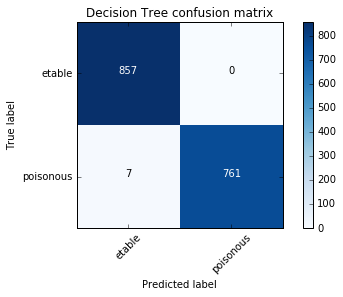

In [30]:
decision_tree = DecisionTreeClassifier(max_depth= 10) # or criterion = "entropy", default = gini
decision_tree.fit(X_train, y_train)

expected = y_test
predicted = decision_tree.predict(X_test)
print("Decision Tree Classifier - results: \n")
acc = accuracy_score(y_test, predicted)
#print(confusion_matrix(y_test, predicted))
print(classification_report(expected, predicted))
print("Accuracy score: {}".format(acc))
print('Training Score: %.2f%%' % (decision_tree.score(X_train, y_train) * 100))
print('Test Score: %.2f%%' % (decision_tree.score(X_test, y_test) * 100))
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes = ["etable", "poisonous"], title = "Decision Tree confusion matrix")
#help(DecisionTreeClassifier)

__Comments:__<br>

The classifier made a total of 1,625 predictions.<br><br>
Out of those 1625 cases, the classifier predicted "1" (or poisonous) 761 times, and "0" (eatable) 864 times.<br> <br>
In reality, 768 species were poisonous, and 857 were not.<br><br>
True positives (predict=p, true=p): 761 <br>
True negatives (predict=e, true=e): 857 <br>
False positives (predict=p, true=e): 0 (Type I error) <br>
False negatives (predict=e, true=p): 7 (type II error) <br><br>
__Accuracy__: Overall, how often is the classifier correct? In 99.6 % of cases <br>
__Recall (true positive rate)__: When it's actually poisonous, how often does it predict poisonous? 99.2%<br>
__Precision__: When it predicts poison, how often is it correct? 100 % cases <br><br>
This is not the greatest model , ideally, if errors are inevitable, in this particular mushroom situation, we would prefer having more false positives rather than that many false negatives. In other words, it would be better to predict that the mushroom is poisonous (while it is etable) and not to consume it, rather than predict that the nushroom is etable while it is actually poisonous. Minimization of Type II error is the ideal approach in this sitation. <br><br>

#### Graphical Representation of the decision tree

To display and save decision trees, save the output as a __.dot__ file.

After getting the .dot file, open with any text editor and paste the code here: http://webgraphviz.com/ to see the picture.

Take a screenshot of the output and save in __.png format__

__Note:__ There are different ways of displaying the tree, however, they didn't work for me.

1. system("dot -Tpng U:/tree2.dot -o U:/tree2.png")

2. graph_from_dot_data(out.getvalue()).write_pdf("U:/tree2.pdf")

In [31]:
from sklearn import tree
dotfile = open('/Users/dariaulybina/Desktop/georgetown/ml_practice/data/tree.dot', 'w')
tree.export_graphviz(decision_tree,out_file=dotfile)
dotfile.close()

In [33]:
#Randomized Parameters Optimization
knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.grid_search import RandomizedSearchCV
params = {'n_neighbors': range(1,5), 'weights': ['uniform','distance']}
research = RandomizedSearchCV(estimator=knn, param_distributions=params, cv=4,n_iter=8,random_state=5)
research.fit(X_train, y_train)
print(research.best_score_)

0.996768733651


In [35]:
print(research.best_estimator_.n_neighbors)

1


K-Neighbors Classifier fit very well with n_neighbors parameter optimal at 1, as found by using Randomized Parameter Optimizer. As most of the models chosen perform well even with only 3 different features acting as predictors, I will use Linear SVC In the next file to explore different encdings, splitting of my data and finally will apply the classifier in the application to make prediction about the classification of a mushroom based on user-input parameters. 